<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
# install mamba to use instead of pip

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [1]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

 'dissertation' environment is ready to use.


In [2]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from transformers import AutoTokenizer
from tqdm.auto import tqdm
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel
import torch.optim as optim
import wandb
import subprocess
import shutil


print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #loading the tokenizer for lyrics processing
print("Tokenizer loaded.")

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import types
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import euclidean

import torch.nn.functional as F

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

⏳ Cloning GitHub repository...
Cloning into 'Dissertation'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 400 (delta 92), reused 64 (delta 64), pack-reused 293 (from 1)
Receiving objects: 100% (400/400), 5.62 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Repository cloned.
Mounted at /content/drive
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.


In [3]:
class MER_Dataset(Dataset):
    """ Custom PyTorch Dataset for loading MER data. """
    def __init__(self, annotations_df, tokenizer):
        """ Creation of the Dataset from the dataframe (predefined splits in MERGE dataset) """
        self.annotations = annotations_df
        self.tokenizer = tokenizer

    def __len__(self):
        """
        Function to return the total number of songs in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Function to get a song from the dataset.
        """
        song_info = self.annotations.iloc[index] #which song ID/row is picked from the dataset as per the index

        spectrogram_path = song_info['spectrogram_path'] # columns from the df
        lyrics_path = song_info['lyrics_path'] # columns from the df
        valence = song_info['valence'] # columns from the df
        arousal = song_info['arousal'] # columns from the df

        #change spectorgram into a tensor
        spectrogram = np.load(spectrogram_path) #loading spectorgram from path saved in df
        spectrogram_tensor = torch.from_numpy(spectrogram).float() # changing the np array to tensor
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0) #Adding a "channel" dimension for CNN

        #Load the lyric tokens
        encoded_lyrics = torch.load(lyrics_path, weights_only=False)
        input_ids = encoded_lyrics['input_ids'].squeeze(0) #remove the batch dimension from input ids so 1d array
        attention_mask = encoded_lyrics['attention_mask'].squeeze(0) #remove the batch dimension from attention mask so 1d

        labels = torch.tensor([valence, arousal], dtype=torch.float32) # extract labels

        return spectrogram_tensor, input_ids, attention_mask, labels

In [4]:
class AttentionModule(nn.Module): #Addition from V1
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        '''
        Attention mechanism to weight the importance of different features
        '''
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),  # input is 64 will map to16
            nn.ReLU(),
            nn.Linear(feature_dim // 4, feature_dim),  #reverts back to 64 from 16
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, 64]
        attention_weights = self.attention(x)  # [batch_size, 64]
        weighted_features = x * attention_weights  # Element-wise multiplication
        return weighted_features

In [5]:
class VGGish_Audio_Model(nn.Module):
    '''As previous vERSION but adding in the following
      - Batch normalisation
      - Attention mechanism
      - Learning rate scheduling
      - early stopping'''

    def __init__(self):
        super(VGGish_Audio_Model, self).__init__()
        '''
        A VGG-style model for the audio tower for a starting model.
        No longer trying to implement the method from MERGE paper as this had mistakes in the paper
        V1.1 includes attention to see if this improves performance.
        V1.2  implements true VGG-style blocks with multiple convolutions per block.
        '''
        self.features = nn.Sequential(
            # Block 1 - 2 convolutions
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2 - 2 convolutions
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3 - 2 convolutions
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4 - 2 convolutions
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.attention = AttentionModule(256) #Add attention here from v2 (model 3)
        self.fc2 = nn.Linear(256, 64) # Final feature vector size should be 64 - needs to match input of combined

    def forward(self, x):
        x = self.features(x)
        # Flatten the features for the classifier
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.attention(x)
        x = self.fc2(x)
        return x

In [6]:
#Data loading and prep

#get the paths to dissertation folder and new folder on colab
print("Starting data transfer from Google Drive to local Colab storage...")

#get paths for old file location and new colab one
gdrive_zip_path = '/content/drive/MyDrive/dissertation/merge_dataset_zipped.zip'
local_storage_path = '/content/local_dissertation_data/'
local_zip_path = os.path.join(local_storage_path, 'merge_dataset_zipped.zip')
os.makedirs(local_storage_path, exist_ok=True) # Ensure the destination directory exists

#Copy zip file from Drive to Colab
print("Copying single archive file from Google Drive...")
!rsync -ah --progress "{gdrive_zip_path}" "{local_storage_path}"

#get total number of files for progress
total_files = int(subprocess.check_output(f"zipinfo -1 {local_zip_path} | wc -l", shell=True))

#unzip the file
print("Extracting files locally")
!unzip -o "{local_zip_path}" -d "{local_storage_path}" | tqdm --unit=files --total={total_files} > /dev/null

print("Data transfer and extraction complete.")

#load master data from new location
local_output_path = os.path.join(local_storage_path, 'merge_dataset/output_from_code/')
master_file_path = os.path.join(local_output_path, 'master_processed_file_list.csv')
master_df = pd.read_csv(master_file_path)

#checking the valence and arousal range in the dataset
print(f"\nValence range in data: [{master_df['valence'].min()}, {master_df['valence'].max()}]")
print(f"Arousal range in data: [{master_df['arousal'].min()}, {master_df['arousal'].max()}]")
print(f"Valence mean: {master_df['valence'].mean():.4f}, std: {master_df['valence'].std():.4f}")
print(f"Arousal mean: {master_df['arousal'].mean():.4f}, std: {master_df['arousal'].std():.4f}")
print(f"Total samples in master_df: {len(master_df)}")

# Verify its the right column - not quadrants
print(f"\nNumber of unique valence values: {master_df['valence'].nunique()}")
print(f"Number of unique arousal values: {master_df['arousal'].nunique()}")
print(f"Number of unique quadrant values: {master_df['quadrant'].nunique()}")

# Sample some actual values
print(f"\nSample valence values: {master_df['valence'].sample(10).values}")
print(f"Sample arousal values: {master_df['arousal'].sample(10).values}")

#update the paths in the csv
print("\nUpdating dataframe paths to use fast local storage...")
gdrive_output_path = '/content/drive/MyDrive/dissertation/output_from_code/'
master_df['spectrogram_path'] = master_df['spectrogram_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
master_df['lyrics_path'] = master_df['lyrics_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
print("Dataframe paths updated.")

#load the data splits from the new path in the predefined splits folder tvt
local_split_folder_path = os.path.join(local_storage_path, 'merge_dataset/MERGE_Bimodal_Complete/tvt_dataframes/tvt_70_15_15/')
train_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_train_bimodal_complete.csv'))
val_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_validate_bimodal_complete.csv'))
test_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_test_bimodal_complete.csv'))
print("\nSplit files loaded from local storage.")

#merge the files
id_column_name = 'song_id'
train_split_df.rename(columns={'Song': id_column_name}, inplace=True)
val_split_df.rename(columns={'Song': id_column_name}, inplace=True)
test_split_df.rename(columns={'Song': id_column_name}, inplace=True)

train_df = pd.merge(master_df, train_split_df, on=id_column_name)
val_df = pd.merge(master_df, val_split_df, on=id_column_name)
test_df = pd.merge(master_df, test_split_df, on=id_column_name)

#checking no files are lost in merging - and checking length of the dataframes.
print("\nchecking data")

#check no data lost in merge
if len(train_df) == len(train_split_df):
    print("\nTraining split: Merge successful. All songs accounted for.")
else:
    print(f"\nWARNING: Training split lost {len(train_split_df) - len(train_df)} songs during merge.")

if len(val_df) == len(val_split_df):
    print("Validation split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Validation split lost {len(val_split_df) - len(val_df)} songs during merge.")

if len(test_df) == len(test_split_df):
    print("Test split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Test split lost {len(test_split_df) - len(test_df)} songs during merge.")

#check length
expected_train_len = 1552
expected_val_len = 332
expected_test_len = 332

assert len(train_df) == expected_train_len, f"Expected {expected_train_len} training samples, but found {len(train_df)}"
assert len(val_df) == expected_val_len, f"Expected {expected_val_len} validation samples, but found {len(val_df)}"
assert len(test_df) == expected_test_len, f"Expected {expected_test_len} test samples, but found {len(test_df)}"

print(f"\nFinal dataset lengths are correct: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")
print("Data Check Complete")

#createthe datasets and loaders
train_dataset = MER_Dataset(annotations_df=train_df, tokenizer=tokenizer)
val_dataset = MER_Dataset(annotations_df=val_df, tokenizer=tokenizer)
test_dataset = MER_Dataset(annotations_df=test_df, tokenizer=tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders created successfully.")

Starting data transfer from Google Drive to local Colab storage...
Copying single archive file from Google Drive...
sending incremental file list
merge_dataset_zipped.zip
          1.23G 100%   35.97MB/s    0:00:32 (xfr#1, to-chk=0/1)
Extracting files locally
4442files [00:15, 290.34files/s]
Data transfer and extraction complete.

Valence range in data: [0.0187499999999999, 0.9875]
Arousal range in data: [0.0625, 0.975]
Valence mean: 0.5050, std: 0.2311
Arousal mean: 0.4823, std: 0.1395
Total samples in master_df: 2216

Number of unique valence values: 465
Number of unique arousal values: 443
Number of unique quadrant values: 4

Sample valence values: [0.296875 0.70625  0.2875   0.78125  0.6025   0.3125   0.2475   0.77125
 0.76625  0.28625 ]
Sample arousal values: [0.31125  0.5625   0.47375  0.27125  0.75625  0.58     0.54625  0.35125
 0.343125 0.50625 ]

Updating dataframe paths to use fast local storage...
Dataframe paths updated.

Split files loaded from local storage.

checking dat

In [7]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA device.")
else:
    # If no GPU is found, print an error and stop execution by raising an error.
    raise RuntimeError("Error: No GPU found. This script requires a GPU to run.")


GPU is available. Using CUDA device.


In [8]:
print("\n" + "="*70)
print("BUILDING SIAMESE ARCHITECTURE")
print("="*70)

class SiameseNetwork(nn.Module):
    """
    The 'Joint Embedding' Model.
    Audio Tower and Lyrics Tower.
    """
    def __init__(self, audio_tower_class, feature_dim=128):
        super(SiameseNetwork, self).__init__()

        #Audio Tower (VGGish)
        self.audio_tower = audio_tower_class()

        #Audio Projector/Translator
        # VGGish outputs 64 features - project this up to 128 (feature_dim).
        self.audio_projector = nn.Sequential(
            nn.Linear(64, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim) # Final embedding size
        )

        #Lyrics Tower (BERT)
        self.lyrics_tower = AutoModel.from_pretrained('bert-base-uncased')
        # Freeze BERT to save memory
        for param in self.lyrics_tower.parameters():
            param.requires_grad = False

        #Lyrics Projector/Translater
        # BERT outputs 768 - project this down to 128 (feature_dim).
        self.lyrics_projector = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim) # Final embedding size
        )

    def forward_audio(self, spec):
        #Extract Features
        feat = self.audio_tower(spec) # Output: 64
        #Project to Shared Space
        emb = self.audio_projector(feat) # Output: 128
        #Normalise for contrastive loss
        return F.normalize(emb, p=2, dim=1)

    def forward_lyrics(self, input_ids, mask):
        #Extract Features
        out = self.lyrics_tower(input_ids=input_ids, attention_mask=mask)
        feat = out.last_hidden_state[:, 0, :] # [CLS] token, size 768
        #Project to Shared Space
        emb = self.lyrics_projector(feat) # Output: 128
        #Normalise for contrastive loss
        return F.normalize(emb, p=2, dim=1)

    def forward(self, spec, input_ids, mask):
        # Return both embeddings
        z_audio = self.forward_audio(spec)
        z_lyrics = self.forward_lyrics(input_ids, mask)
        return z_audio, z_lyrics

class ContrastiveLoss(nn.Module):
    """
    The 'Magnet' Loss Function.
    - Pulls matching (positive) pairs together.
    - Pushes mismatched (negative) pairs apart.
    """
    def __init__(self, temperature=0.07): #STARTING PT - USED BY SIMCLR BUT CAN DECREASE IF DOESN'T DECREASE
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, audio_embeddings, lyrics_embeddings):
        # Calculate Similarity Matrix (Audio x Lyrics)
        logits = torch.matmul(audio_embeddings, lyrics_embeddings.T) / self.temperature #divide by temperature to sharpen the probability distribution

        # The "Correct Answer" is the diagonal (0, 1, 2...)
        labels = torch.arange(logits.shape[0]).to(logits.device)

        # Calculate Loss Audio->Lyrics and Lyrics->Audio (Symmetric Loss)
        loss_a = self.criterion(logits, labels)
        loss_l = self.criterion(logits.T, labels)

        return (loss_a + loss_l) / 2

# Initialise the Model and Loss
siamese_model = SiameseNetwork(VGGish_Audio_Model).to(device)
contrastive_loss = ContrastiveLoss(temperature=0.07).to(device)

print("Siamese Model created (Audio & Lyrics projecting to 128 dimensions)")
print("Contrastive Loss ready")


BUILDING SIAMESE ARCHITECTURE


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Siamese Model created (Audio & Lyrics projecting to 128 dimensions)
Contrastive Loss ready


In [10]:

print("\n" + "="*70)
print("TRAINING SIAMESE NETWORK (CONTRASTIVE LEARNING)")
print("="*70)

# --- CONFIGURATION ---
NUM_EPOCHS = 30 # Contrastive converges faster than regression usually
LEARNING_RATE = 1e-4 # Lower learning rate is better for Siamese stability
PATIENCE = 5 # Early stopping

#Optimiser
optimizer = optim.Adam(siamese_model.parameters(), lr=LEARNING_RATE)

#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

#start Tracking
best_val_loss = float('inf')
patience_counter = 0

# Start W&B
wandb.init(project="dissertation-siamese", name="contrastive-training-v1")

for epoch in range(NUM_EPOCHS):
    # --- TRAINING LOOP ---
    siamese_model.train()
    total_train_loss = 0

    for spec, input_ids, mask, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        # Move to GPU
        spec = spec.to(device)
        input_ids = input_ids.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        # Forward Pass (Get the two vectors)
        z_audio, z_lyrics = siamese_model(spec, input_ids, mask)

        #Calculate Contrastive Loss
        # (Pull matching pair together, push others in batch apart)
        loss = contrastive_loss(z_audio, z_lyrics)

        #Backward Pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- VALIDATION LOOP ---
    siamese_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for spec, input_ids, mask, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            spec = spec.to(device)
            input_ids = input_ids.to(device)
            mask = mask.to(device)

            # Get embeddings
            z_audio, z_lyrics = siamese_model(spec, input_ids, mask)

            # Calculate Loss
            loss = contrastive_loss(z_audio, z_lyrics)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # --- LOGGING ---
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "epoch": epoch+1})
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")
    wandb.log({"learning_rate": current_lr})

    # --- EARLY STOPPING ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(siamese_model.state_dict(), 'best_siamese_model.pth')
        print(f"  ✓ New best model saved! (Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("  Early stopping triggered")
            break

    # Update Learning Rate
    scheduler.step(avg_val_loss)

print("Training Complete.")
wandb.finish()


TRAINING SIAMESE NETWORK (CONTRASTIVE LEARNING)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gemwrigley (gemwrigley-university-of-bath) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 1 | Train Loss: 2.7643 | Val Loss: 2.3996
Current Learning Rate: 0.0001
  ✓ New best model saved! (Loss: 2.3996)


Epoch 2/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 2 | Train Loss: 2.4523 | Val Loss: 2.3837
Current Learning Rate: 0.0001
  ✓ New best model saved! (Loss: 2.3837)


Epoch 3/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch 3 | Train Loss: 2.3506 | Val Loss: 2.6461
Current Learning Rate: 0.0001
  No improvement (1/5)


Epoch 4/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.12it/s]


Epoch 4 | Train Loss: 2.2877 | Val Loss: 2.3391
Current Learning Rate: 0.0001
  ✓ New best model saved! (Loss: 2.3391)


Epoch 5/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.10it/s]


Epoch 5 | Train Loss: 2.2342 | Val Loss: 2.1654
Current Learning Rate: 0.0001
  ✓ New best model saved! (Loss: 2.1654)


Epoch 6/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 6 | Train Loss: 2.2096 | Val Loss: 2.1819
Current Learning Rate: 0.0001
  No improvement (1/5)


Epoch 7/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.05it/s]


Epoch 7 | Train Loss: 2.1782 | Val Loss: 2.5052
Current Learning Rate: 0.0001
  No improvement (2/5)


Epoch 8/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.05it/s]


Epoch 8 | Train Loss: 2.0918 | Val Loss: 2.1787
Current Learning Rate: 0.0001
  No improvement (3/5)


Epoch 9/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 9 | Train Loss: 2.0471 | Val Loss: 2.1412
Current Learning Rate: 5e-05
  ✓ New best model saved! (Loss: 2.1412)


Epoch 10/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 10 | Train Loss: 2.0301 | Val Loss: 2.1516
Current Learning Rate: 5e-05
  No improvement (1/5)


Epoch 11/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.05it/s]


Epoch 11 | Train Loss: 2.0289 | Val Loss: 2.1109
Current Learning Rate: 5e-05
  ✓ New best model saved! (Loss: 2.1109)


Epoch 12/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 12 | Train Loss: 2.0046 | Val Loss: 2.1667
Current Learning Rate: 5e-05
  No improvement (1/5)


Epoch 13/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 13 | Train Loss: 1.9684 | Val Loss: 2.1425
Current Learning Rate: 5e-05
  No improvement (2/5)


Epoch 14/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 14 | Train Loss: 1.9928 | Val Loss: 2.0945
Current Learning Rate: 5e-05
  ✓ New best model saved! (Loss: 2.0945)


Epoch 15/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch 15 | Train Loss: 2.0097 | Val Loss: 2.1116
Current Learning Rate: 5e-05
  No improvement (1/5)


Epoch 16/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch 16 | Train Loss: 1.9539 | Val Loss: 2.0606
Current Learning Rate: 5e-05
  ✓ New best model saved! (Loss: 2.0606)


Epoch 17/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 17 | Train Loss: 1.9372 | Val Loss: 2.1346
Current Learning Rate: 5e-05
  No improvement (1/5)


Epoch 18/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 18 | Train Loss: 1.9774 | Val Loss: 2.0784
Current Learning Rate: 5e-05
  No improvement (2/5)


Epoch 19/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


Epoch 19 | Train Loss: 1.9009 | Val Loss: 2.0366
Current Learning Rate: 5e-05
  ✓ New best model saved! (Loss: 2.0366)


Epoch 20/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


Epoch 20 | Train Loss: 1.8566 | Val Loss: 2.1462
Current Learning Rate: 5e-05
  No improvement (1/5)


Epoch 21/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch 21 | Train Loss: 1.8486 | Val Loss: 2.2885
Current Learning Rate: 5e-05
  No improvement (2/5)


Epoch 22/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 22 | Train Loss: 1.8725 | Val Loss: 2.0781
Current Learning Rate: 5e-05
  No improvement (3/5)


Epoch 23/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 23 | Train Loss: 1.8341 | Val Loss: 2.0138
Current Learning Rate: 2.5e-05
  ✓ New best model saved! (Loss: 2.0138)


Epoch 24/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 24 | Train Loss: 1.8363 | Val Loss: 2.0361
Current Learning Rate: 2.5e-05
  No improvement (1/5)


Epoch 25/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.04it/s]


Epoch 25 | Train Loss: 1.7958 | Val Loss: 2.1912
Current Learning Rate: 2.5e-05
  No improvement (2/5)


Epoch 26/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 26 | Train Loss: 1.7948 | Val Loss: 2.1075
Current Learning Rate: 2.5e-05
  No improvement (3/5)


Epoch 27/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


Epoch 27 | Train Loss: 1.7982 | Val Loss: 2.0337
Current Learning Rate: 1.25e-05
  No improvement (4/5)


Epoch 28/30 [Val]: 100%|██████████| 21/21 [00:02<00:00,  7.04it/s]

Epoch 28 | Train Loss: 1.7495 | Val Loss: 2.0367
Current Learning Rate: 1.25e-05
  No improvement (5/5)
  Early stopping triggered
Training Complete.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
learning_rate,████████▄▄▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▁▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁
val_loss,▅▅█▅▃▃▆▃▂▃▂▃▂▂▂▂▂▂▁▂▄▂▁▁▃▂▁▁
epoch,28
learning_rate,1e-05
train_loss,1.74947
val_loss,2.03666


In [11]:

print("\n" + "="*70)
print("SAVING TRAINED SIAMESE MODEL TO DRIVE")
print("="*70)

# Define paths
local_path = 'best_siamese_model.pth'
drive_dir = '/content/drive/MyDrive/dissertation/'
drive_path = os.path.join(drive_dir, 'siamese_contrastive_model.pth')

# Move the file
if os.path.exists(local_path):
    shutil.copy(local_path, drive_path)
    print(f"✓ Success! Model saved to: {drive_path}")
else:
    print(" Warning: 'best_siamese_model.pth' not found. Did the training finish?")


SAVING TRAINED SIAMESE MODEL TO DRIVE
✓ Success! Model saved to: /content/drive/MyDrive/dissertation/siamese_contrastive_model.pth



TESTING: Retreival
Extracting Test Set Embeddings...


100%|██████████| 21/21 [00:02<00:00,  7.01it/s]



Comparing 332 songs...
----------------------------------------
RETRIEVAL ACCURACY: 84.94%
----------------------------------------
Verdict: EXCELLENT. Strong alignment between modalities.

Graph saved to: /content/drive/MyDrive/dissertation/siamese_retrieval_result.png


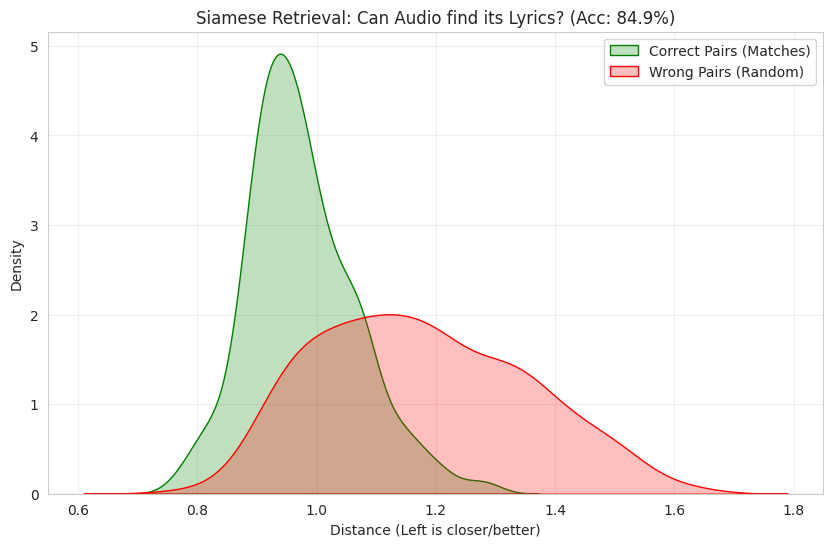

In [12]:

print("\n" + "="*70)
print("TESTING: Retreival")
print("="*70)

#Load the Best Model
siamese_model.load_state_dict(torch.load('best_siamese_model.pth'))
siamese_model.eval()

#Extract Embeddings for the Test Set
test_audio_embeddings = []
test_lyrics_embeddings = []

print("Extracting Test Set Embeddings...")
with torch.no_grad():
    for spec, input_ids, mask, _ in tqdm(test_loader):
        spec = spec.to(device)
        input_ids = input_ids.to(device)
        mask = mask.to(device)

        # Get the vectors (z_audio, z_lyrics)
        z_a, z_l = siamese_model(spec, input_ids, mask)

        test_audio_embeddings.append(z_a.cpu().numpy())
        test_lyrics_embeddings.append(z_l.cpu().numpy())

# Concatenate into one big list
a_emb = np.concatenate(test_audio_embeddings)
l_emb = np.concatenate(test_lyrics_embeddings)

#Matching
correct_pair_dists = []
wrong_pair_dists = []
matches = 0
total_songs = len(a_emb)

# Shuffle indices for random comparison
random_indices = np.arange(total_songs)
np.random.shuffle(random_indices)

print(f"\nComparing {total_songs} songs...")

for i in range(total_songs):
    # Distance to CORRECT lyrics
    dist_correct = euclidean(a_emb[i], l_emb[i])
    correct_pair_dists.append(dist_correct)

    # Distance to RANDOM (Wrong) lyrics
    wrong_idx = random_indices[i]
    if wrong_idx == i: wrong_idx = (i + 1) % total_songs # Ensure it's not the same song

    dist_wrong = euclidean(a_emb[i], l_emb[wrong_idx])
    wrong_pair_dists.append(dist_wrong)

    # Assess whether correct
    if dist_correct < dist_wrong:
        matches += 1

#Calculate Accuracy
accuracy = (matches / total_songs) * 100

print("-" * 40)
print(f"RETRIEVAL ACCURACY: {accuracy:.2f}%")
print("-" * 40)

if accuracy > 90:
    print("Verdict: TELEPATHIC. The Audio and Lyrics are virtually inseparable.")
elif accuracy > 80:
    print("Verdict: EXCELLENT. Strong alignment between modalities.")
elif accuracy > 60:
    print("Verdict: GOOD. The model learned a shared language.")
else:
    print("Verdict: WEAK. The 'Magnets' didn't stick well.")

#Plot the Separation
plt.figure(figsize=(10, 6))
sns.kdeplot(correct_pair_dists, fill=True, color='green', label='Correct Pairs (Matches)')
sns.kdeplot(wrong_pair_dists, fill=True, color='red', label='Wrong Pairs (Random)')
plt.title(f"Siamese Retrieval: Can Audio find its Lyrics? (Acc: {accuracy:.1f}%)")
plt.xlabel("Distance (Left is closer/better)")
plt.legend()
plt.grid(True, alpha=0.3)

save_path = '/content/drive/MyDrive/dissertation/siamese_retrieval_result.png'
plt.savefig(save_path)
print(f"\nGraph saved to: {save_path}")
plt.show()

In [13]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

print("\n" + "="*70)
print("GENERATING DETAILED EXCEL REPORT (RANK ANALYSIS)")
print("="*70)

#Calculate the full Distance Matrix (Audio x Lyrics)
print("Calculating distance matrix for all possible pairs...")
#calculate all euclidean distances
dist_matrix = cdist(a_emb, l_emb, metric='euclidean')

#create blank lists
ranks = []
correct_distances = []
nearest_neighbor_dists = []
is_top_1 = []
is_top_5 = []
is_top_10 = []

# song level results
num_songs = len(dist_matrix)

for i in range(num_songs):
    # Get all distances for Audio song 'i' against all Lyrics
    dists_for_song = dist_matrix[i]

    # The distance to the CORRECT lyrics is at index 'i'
    correct_dist = dists_for_song[i]
    correct_distances.append(correct_dist)

    # Sort distances to find the Rank - smallest first
    sorted_indices = np.argsort(dists_for_song)

    # Find where the correct index 'i' falls in the sorted list
    rank = np.where(sorted_indices == i)[0][0] + 1
    ranks.append(rank)

    # Distance to the closest
    nearest_neighbor_dists.append(dists_for_song[sorted_indices[0]])

    # Check "Recall" metrics
    is_top_1.append(1 if rank == 1 else 0)
    is_top_5.append(1 if rank <= 5 else 0)
    is_top_10.append(1 if rank <= 10 else 0)

#Create the DataFrame
results_df = test_df[['song_id', 'valence', 'arousal']].copy()

results_df['correct_pair_distance'] = correct_distances
results_df['rank'] = ranks
results_df['is_exact_match'] = is_top_1
results_df['in_top_5'] = is_top_5

#Calculate Summary Stats
mean_rank = np.mean(ranks)
median_rank = np.median(ranks)
recall_at_1 = np.mean(is_top_1) * 100
recall_at_5 = np.mean(is_top_5) * 100

print(f"\n--- REPORT SUMMARY ---")
print(f"Mean Rank: {mean_rank:.1f} (Lower is better, 1.0 is perfect)")
print(f"Median Rank: {median_rank:.0f}")
print(f"Recall@1 (Exact Match): {recall_at_1:.1f}%")
print(f"Recall@5 (Top 5):       {recall_at_5:.1f}%")

#Save to Excel
excel_path = '/content/drive/MyDrive/dissertation/siamese_test_results.xlsx'
try:
    results_df.to_excel(excel_path, index=False)
    print(f"\n✅ detailed report saved to: {excel_path}")
except Exception as e:
    print(f"Error saving Excel: {e}")


GENERATING DETAILED EXCEL REPORT (RANK ANALYSIS)
Calculating distance matrix for all possible pairs...

--- REPORT SUMMARY ---
Mean Rank: 61.2 (Lower is better, 1.0 is perfect)
Median Rank: 42
Recall@1 (Exact Match): 1.2%
Recall@5 (Top 5):       9.3%

✅ detailed report saved to: /content/drive/MyDrive/dissertation/siamese_test_results.xlsx
